# Table of Contents

- In this notebook, we'll learn about:
- Topic Modelling
  - Latent Dirichlet Allocation (LDA)
  - Truncated SVD (Truncated Singular Value Decomposition)

- Dimension Reduction
  - Principal Component Analysis (PCA)
  - Linear Discriminant Analysis (LDA)
  - Truncated SVD (Truncated Singular Value Decomposition)

<br>

## Topic Modelling

- Topic modeling in NLP discovers abstract themes in document collections using algorithms like LDA (Latent Dirichlet Allocation), LSA (Latent Semantic Analysis), etc. 
- It's unsupervised, clusters similar expressions, and aids in organizing, summarizing, and analyzing large text datasets.

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

### Latent Dirichlet Allocation (LDA)

- LDA is a generative probabilistic model that tries to find groups of words that appear frequently together across different documents.
- It assumes that each document is a mixture of topics, and each topic is a distribution over words.
- LDA assumes documents are "bags of words." i.e. the order of words doesn't matter, and only the frequency of word occurrences is considered.
  - This is a simplification, as word order can be important for understanding meaning.

In [3]:
fp: str = "../../data/ImDB_data.parquet"
df: pl.DataFrame = pl.read_parquet(fp)
df.head(2)

review,sentiment
str,i64
"""I felt this movie was as much about human sexuality as anything else, whether intentionally or not. We are also shown how absurd and paradoxical it is for women not to be allowed to such a nationally important event, meanwhile forgetting the pasts of our respective ""advanced"" nations. I write from Japan, where women merely got the right to vote 60 years ago, and female technical engineers are a recent phenomenon. Pubs in England were once all-male, the business world was totally off-limits for women in America until rather recently, and women in China had their feet bound so they couldn't develop feet strong enough to escape their husbands. Iran is conveniently going through this stage in our time, and we get a good look at how ridiculous we have all looked at one time or another. Back to the issue of sexuality, we are made to wonder what it may be intrinsically about women that make them unfit for a soccer game (the official reason is that the men are bad). Especially such boyish gir…",1
"""Let's face it, a truly awful movie, no...I mean a ""truly"" awful movie, is a rare, strange, and beautiful thing to behold. I admite that there is a special place in my heart for films like Plan 9 From Outer Space, Half Caste, Species, etc. And although I'm giving this film a 1, I highly urge anyone who enjoys a bad film for what it truly is (a bad film) to find a friend, snacks, something to drink, and make the special occasion it deserves out of: Aussie Park Boyz. <br /><br />From the very first moments of the lead actor's side to side eye-rolling performance as he attempts to inject intensity directly into the film without ever looking at a camera (a slice of ham straight out of silent pictures--eat your heart out Rudolph Valentino) to the sudden hey-we're-out-of-film conclusion, you...will...not...stop...laughing. <br /><br />To sum the film up, its a poor man's Warriors down under, complete--and that description alone should be enough, but then comes the wonders of ""the spaghetti e…",0


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import csr_matrix


n_components: int = 10  # number of topics
max_features: int = 5_000  # number of words to keep

count: CountVectorizer = CountVectorizer(
    stop_words="english", max_df=0.1, max_features=max_features
)
review: list[str] = df.select("review").to_numpy().squeeze().tolist()
X: csr_matrix = count.fit_transform(review)


lda = LatentDirichletAllocation(
    n_components=n_components, random_state=123, learning_method="online"
)
X_topics = lda.fit_transform(X)

In [5]:
# 5_000 features per topic. i.e. 10 topics, 5_000 features.
lda.components_.shape

(10, 5000)

In [6]:
np.argsort?

Signature:       np.argsort(a, axis=-1, kind=None, order=None)
Call signature:  np.argsort(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function argsort at 0x10d95ade0>
File:            ~/miniconda3/envs/torch_p11/lib/python3.11/site-packages/numpy/core/fromnumeric.py
Docstring:      
Returns the indices that would sort an array.

Perform an indirect sort along the given axis using the algorithm specified
by the `kind` keyword. It returns an array of indices of the same shape as
`a` that index data along the given axis in sorted order.

Parameters
----------
a : array_like
    Array to sort.
axis : int or None, optional
    Axis along which to sort.  The default is -1 (the last axis). If None,
    the flattened array is used.
kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
    Sorting algorithm. The default is 'quicksort'. Note that both 'stable'
    and 'mergesort' use timsort under the covers and, in general, the
    actual implementa

In [7]:
my_arr: np.ndarray = np.array([4, 2, -20, 8, 0, 5])
# By default, it returns the idxs that would sort the array in ascending order
# array([2, 4, 1, 0, 5, 3])
default: np.ndarray = my_arr.argsort()
print(f"{default = }")

rev_default: np.ndarray = my_arr.argsort()[::-1]
print(f"{rev_default = }")

# This is more intuitive!
rev_top_3: np.ndarray = my_arr.argsort()[::-1][:3]
print(f"{rev_top_3 = }")

# Less intuitive
rev_top_3_b: np.ndarray = my_arr.argsort()[: -3 - 1 : -1]
print(f"{rev_top_3_b = }")

default = array([2, 4, 1, 0, 5, 3])
rev_default = array([3, 5, 0, 1, 4, 2])
rev_top_3 = array([3, 5, 0])
rev_top_3_b = array([3, 5, 0])


In [9]:
n_top_words: int = 5  # Number of top words to display for each topic
components: np.ndarray = lda.components_
feature_names: np.ndarray = count.get_feature_names_out()

for i, topic in enumerate(components):
    top_features_ind: np.ndarray = topic.argsort()[::-1][:n_top_words]
    top_features: list[str] = [feature_names[i] for i in top_features_ind]
    print(f"Topic {i + 1}: {' '.join(top_features)}")
    print("===" * 20)

Topic 1: worst guy minutes script money
Topic 2: audience feel sense camera cinema
Topic 3: music song musical john songs
Topic 4: horror killer dead blood gore
Topic 5: comedy series tv episode fun
Topic 6: role book performance played actor
Topic 7: family father woman mother wife
Topic 8: original version dvd kids children
Topic 9: american western town police common
Topic 10: action war fight space fi


In [10]:
feature_names.shape

(5000,)

### Comment

- Topic 1: Low-budget flop with bad script

- Topic 2: Artistic film with deep cinematography

- Topic 3: Musical biopic with catchy tunes

- Topic 4: Gory slasher with gruesome deaths

- Topic 5: Entertaining sitcom or comedy series

- Topic 6: Book adaptation with stellar acting

- Topic 7: Family drama exploring domestic relationships

- Topic 8: Remastered children's movie on DVD

- Topic 9: Classic Western or police drama

- Topic 10: Sci-fi action with space battles


<hr><br>

### TruncatedSVD (Latent Semantic Analysis)

- TruncatedSVD (Truncated Singular Value Decomposition) is a dimensionality reduction technique commonly used in natural language processing and text classification tasks.
- It's particularly useful for sparse matrices, such as those created by TF-IDF vectorization.

**Overview of TruncatedSVD**:
  - It reduces the number of features while preserving the most important information.
  - It helps address the "curse of dimensionality" in high-dimensional datasets.
  - It can improve computational efficiency and reduce noise in the data.
  - Unlike regular SVD, it only computes the top k singular values and vectors, making it faster and more memory-efficient.
  - It's often used as part of a pipeline in text classification, following TF-IDF vectorization.
  - It works best as a dimensionality reduction `(feature extraction)` technique during model training.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


n_components: int = 10  # number of topics
max_features: int = 5_000  # number of words to keep
random_state: int = 123  # for reproducibility

# Generate the tf-idf matrix for the two sets.
# Create the tf-idf vectorizer.
vectorizer: TfidfVectorizer = TfidfVectorizer(
    stop_words="english", max_features=max_features
)
X: csr_matrix = vectorizer.fit_transform(review)


svd: TruncatedSVD = TruncatedSVD(
    n_components=n_components, n_iter=5, random_state=random_state, tol=0.0
)
X_topics: np.ndarray = svd.fit_transform(X)
print(f"{X_topics.shape = }")

cum_var_ratio: np.ndarray = svd.explained_variance_ratio_.cumsum()
print(f"{cum_var_ratio = }")

X_topics.shape = (50000, 10)
cum_var_ratio = array([0.0094, 0.0202, 0.0268, 0.0305, 0.0337, 0.0363, 0.0389, 0.0411,
       0.0434, 0.0455])


In [12]:
components: np.ndarray = svd.components_
feature_names: np.ndarray = vectorizer.get_feature_names_out()

n_top_words: int = 5  # Number of top words to display for each topic
for i, topic in enumerate(components):
    top_features_ind: np.ndarray = topic.argsort()[::-1][:n_top_words]
    top_features: list[str] = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    print(f"Topic {i + 1}: {' '.join(top_features)}")

Topic 1: br movie film like just
Topic 2: br spoilers uk spoiler rates
Topic 3: movie br movies bad watch
Topic 4: film bad worst acting horror
Topic 5: movie film great story book
Topic 6: great funny series watch really
Topic 7: good great bad series acting
Topic 8: series book seen tv time
Topic 9: horror seen movies ve films
Topic 10: bad funny worst seen comedy


### Topic Clasification

In [13]:
from sklearn.datasets import fetch_20newsgroups


# Load the news data and print the names of the categories.
news: tuple[Any] = fetch_20newsgroups(subset="all")

# Print various information about the data.
print(f"Number of articles {len(news.data):,}")
print(f"Number of categories {len(news.target_names):,}")

Number of articles 18,846
Number of categories 20


In [14]:
console.print(news.target_names)

[
    'alt.atheism',
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'misc.forsale',
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.electronics',
    'sci.med',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.politics.misc',
    'talk.religion.misc'
]

In [15]:
news.data[0]

"From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

In [16]:
console.print("".join(news.data[0].split("\n")))

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>Subject: Pens fans reactionsOrganization: Post Office, Carnegie
Mellon, Pittsburgh, PALines: 12NNTP-Posting-Host: po4.andrew.cmu.eduI am sure some bashers of Pens fans are pretty 
confused about the lackof any kind of posts about the recent Pens massacre of the Devils. Actually,I am  bit 
puzzled too and a bit relieved. However, I am going to put an endto non-PIttsburghers' relief with a bit of praise 
for the Pens. Man, theyare killing those Devils worse than I thought. Jagr just showed you whyhe is much better 
than his regular season stats. He is also a lotfo fun to watch in the playoffs. Bowman should let JAgr have a lot 
offun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very 
disappointed not to see the Islanders lose the finalregular season game.          PENS RULE!!!

In [17]:
from collections import Counter

dir(news)


counts: Counter = Counter(news.target)

target_mapper: dict[str, str] = {
    idx: name for idx, name in enumerate(news.target_names)
}

console.print(target_mapper)
samples_per_category: dict[str, int] = {target_mapper[k]: v for k, v in counts.items()}
console.print(f"{samples_per_category = }")

{
    0: 'alt.atheism',
    1: 'comp.graphics',
    2: 'comp.os.ms-windows.misc',
    3: 'comp.sys.ibm.pc.hardware',
    4: 'comp.sys.mac.hardware',
    5: 'comp.windows.x',
    6: 'misc.forsale',
    7: 'rec.autos',
    8: 'rec.motorcycles',
    9: 'rec.sport.baseball',
    10: 'rec.sport.hockey',
    11: 'sci.crypt',
    12: 'sci.electronics',
    13: 'sci.med',
    14: 'sci.space',
    15: 'soc.religion.christian',
    16: 'talk.politics.guns',
    17: 'talk.politics.mideast',
    18: 'talk.politics.misc',
    19: 'talk.religion.misc'
}

samples_per_category = {'rec.sport.hockey': 999, 'comp.sys.ibm.pc.hardware': 982, 'talk.politics.mideast': 940, 
'comp.sys.mac.hardware': 963, 'sci.electronics': 984, 'talk.religion.misc': 628, 'sci.crypt': 991, 'sci.med': 990, 
'alt.atheism': 799, 'rec.motorcycles': 996, 'rec.autos': 990, 'comp.windows.x': 988, 'comp.graphics': 973, 
'sci.space': 987, 'talk.politics.guns': 910, 'misc.forsale': 975, 'rec.sport.baseball': 994, 'talk.politics.misc': 
775, 'comp.os.ms-windows.misc': 985, 'soc.religion.christian': 997}

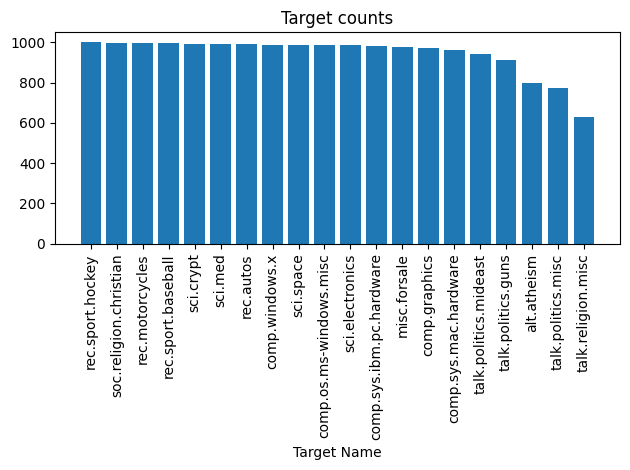

In [18]:
# Sort the dataframe by the number of targets
samples_per_category = dict(
    sorted(samples_per_category.items(), key=lambda x: x[1], reverse=True)
)

plt.bar(x=samples_per_category.keys(), height=samples_per_category.values())
plt.xticks(rotation=90)
plt.title("Target counts")
plt.xlabel("Target Name")
plt.tight_layout()
plt.show()

### Visualize the common n-grams in a given topic

In [19]:
from sklearn.feature_extraction.text import CountVectorizer


vect: CountVectorizer = CountVectorizer(
    ngram_range=(2, 2),
    max_features=5_000,
    stop_words="english",
)

data: list[str] = []

for d, idx in zip(news.data, news.target):
    if idx == 12:  # 'sci.electronics'
        data.append(d)

words = vect.fit_transform(data)

In [20]:
vect.get_feature_names_out()

array(['00 box', '00 gmt', '000 000', ..., 'zoo toronto',
       'zoology kipling', 'zoology lines'], dtype=object)

In [21]:
words_sum: np.ndarray = words.toarray().sum(axis=0)

# index of the top 20 bi-grams
top_idxs: np.ndarray = words_sum.argsort()[::-1][:20]
bi_gram_dict: dict[str, int] = {
    bi_gram: val
    for val, bi_gram in zip(words_sum[top_idxs], vect.get_feature_names_out()[top_idxs])
}
bi_gram_dict

{'posting host': 444,
 'nntp posting': 444,
 'organization university': 140,
 'hp com': 119,
 'edu au': 107,
 'distribution world': 84,
 'don know': 82,
 'writes article': 80,
 'edu organization': 80,
 'nasa gov': 75,
 'ac uk': 75,
 'does know': 72,
 'copy protection': 70,
 'bison mb': 69,
 'mb ca': 69,
 'lead acid': 65,
 'copy protected': 61,
 'newsreader tin': 60,
 'university lines': 60,
 'thanks advance': 59}

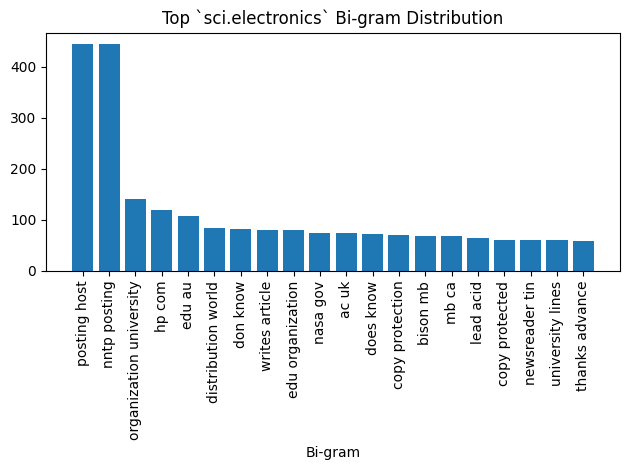

In [22]:
# Sort the dataframe by the number of targets
bi_gram_dict = dict(sorted(bi_gram_dict.items(), key=lambda x: x[1], reverse=True))

plt.bar(x=bi_gram_dict.keys(), height=bi_gram_dict.values())
plt.xticks(rotation=90)
plt.title("Top `sci.electronics` Bi-gram Distribution")
plt.xlabel("Bi-gram")
plt.tight_layout()
plt.show()

## Dimensionality Reduction

### Principal Component Analysis

- `PCA` (Principal Component Analysis) is a powerful dimensionality reduction technique used in data analysis and machine learning. 

- **Goal**: Simplify complex data while preserving important information. i.e. reduce the number of dimensions in a dataset while retaining as much information as possible. (capture maximum variance with fewer dimensions)

- **Process**:
  - Finds the directions (principal components) where data varies the most.
  - Ranks these directions by importance.
  - Projects data onto these new directions.

- **Benefits**:
  - Reduces data complexity
  - Helps visualize high-dimensional data
  - Removes noise and redundant information

- **Applications**:
  - Image compression
  - Feature extraction
  - Data visualization
  - Preprocessing for machine learning models

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA


categories: list[str] = [
    "soc.religion.christian",
    "talk.politics.guns",
    "talk.religion.misc",
]

news: list[Any] = fetch_20newsgroups(categories=categories)

# Reduce the size of the dataset
N: int = 2_000
data_samples: list[str] = news.data[:N]
data_target: list[int] = news.target[:N]

# Vectorize the data
vect: TfidfVectorizer = TfidfVectorizer(stop_words="english", max_features=500)
X: csr_matrix = vect.fit_transform(data_samples)

# Calculate the PCA with 2 components
pca: PCA = PCA(n_components=2)
# X has already been scaled, so we don't need to scale it again
X_pca: csr_matrix = pca.fit_transform(X.toarray())

In [24]:
# It shows how much information (variance) can be attributed to each of the principal components.
explained_var_ratio: np.ndarray = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_var_ratio}\n")

# Cumulative explained variance reveals total variance captured by increasing components, guiding
# optimal dimensionality reduction while preserving essential information in PCA analysis
cumulative_var_ratio: np.ndarray = np.cumsum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance ratio: {cumulative_var_ratio}")

Explained variance ratio: [0.0289 0.0186]

Cumulative explained variance ratio: [0.0289 0.0474]


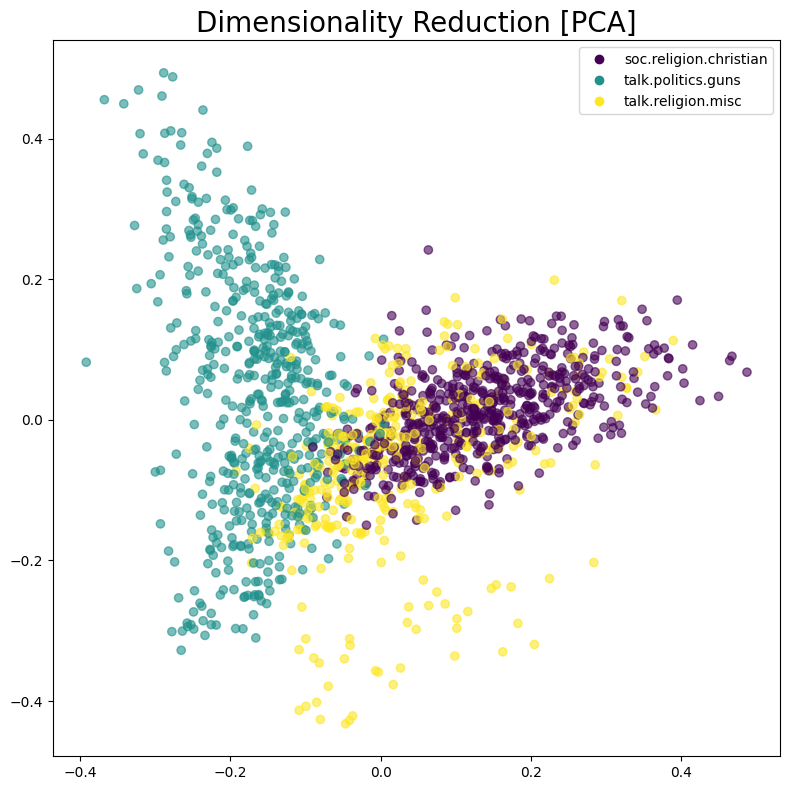

In [25]:
# Plot the reduced data
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, c=data_target)
labels = np.unique(data_target)
plt.title("Dimensionality Reduction [PCA]", fontsize=20)
handles = [
    plt.Line2D([], [], marker="o", ls="", color=scatter.cmap(scatter.norm(i)))
    for i in labels
]
plt.legend(handles, categories)
plt.tight_layout()
plt.show()

<hr><br>

### Linear Disciminant Analysis (LDA)

- `Linear Discriminant Analysis` (LDA) is a powerful technique for both dimensionality reduction and classification.
- It's a supervised learning method that aims to find a linear combination of features that best separates the classes.

- **Goal**: Maximize separation between different classes while minimizing variation within each class.

- **Process**:
  - Finds directions (linear discriminants) that best separate classes.
  - Projects data onto these directions to create a lower-dimensional space.
  - Key idea: Optimize class separability for better classification.

- **Benefits**:
  - Reduces dimensionality while preserving class-discriminative information.
  - Can be used for multi-class problems.
  - Often performs well with small sample sizes.

- **Applications**:
  - Face recognition
  - Marketing customer segmentation
  - Medical diagnosis
  - Speech recognition

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda: LinearDiscriminantAnalysis = LinearDiscriminantAnalysis(n_components=2)
# X has already been scaled, so we don't need to scale it again
X_lda: np.ndarray = lda.fit_transform(X.toarray(), data_target)

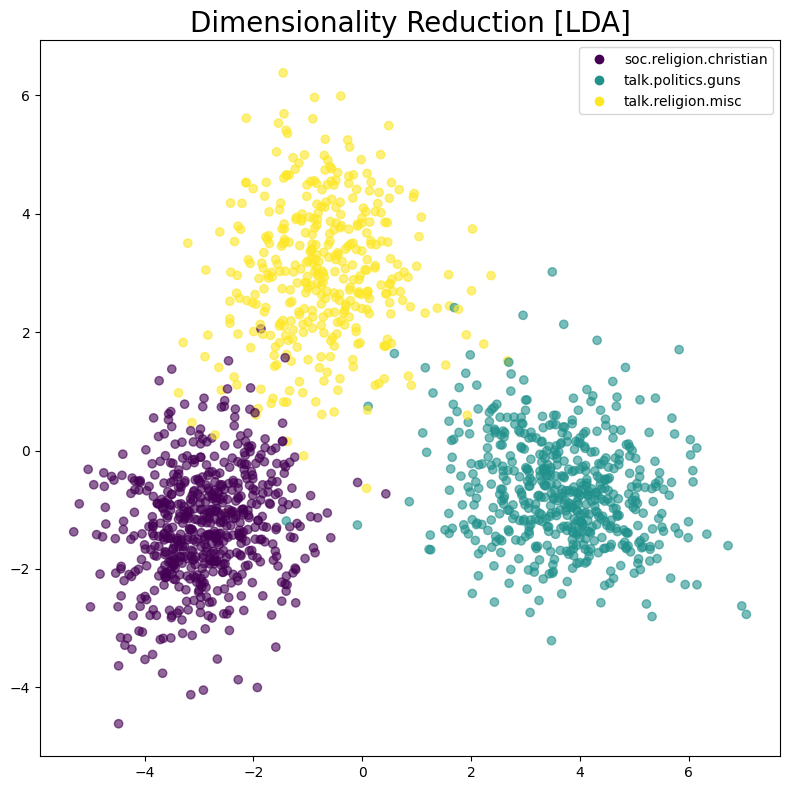

In [27]:
# Plot the reduced data
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], alpha=0.6, c=data_target)
labels = np.unique(data_target)
plt.title("Dimensionality Reduction [LDA]", fontsize=20)
handles = [
    plt.Line2D([], [], marker="o", ls="", color=scatter.cmap(scatter.norm(i)))
    for i in labels
]
plt.legend(handles, categories)
plt.tight_layout()
plt.show()

In [28]:
# Print the 10 top words per news category.
feature_names: np.ndarray = vect.get_feature_names_out()

for i, category in enumerate(categories):
    top_idx: np.ndarray = np.argsort(lda.coef_[i])[-10:]
    console.print(f"{category!r}: {' '.join(feature_names[top_idx])}")

'soc.religion.christian': married happen experience maybe st arrogance subject lines clh rutgers

'talk.politics.guns': guns wouldn firearm rights atf large waco distribution standard nntp

'talk.religion.misc': agree brian doctrine morality order sort mr sandvik nntp lines

In [29]:
# Shape: (n_topics, n_features)
lda.coef_.shape

(3, 500)

### Build A Classifier

In [30]:
samples_per_category

{'rec.sport.hockey': 999,
 'soc.religion.christian': 997,
 'rec.motorcycles': 996,
 'rec.sport.baseball': 994,
 'sci.crypt': 991,
 'sci.med': 990,
 'rec.autos': 990,
 'comp.windows.x': 988,
 'sci.space': 987,
 'comp.os.ms-windows.misc': 985,
 'sci.electronics': 984,
 'comp.sys.ibm.pc.hardware': 982,
 'misc.forsale': 975,
 'comp.graphics': 973,
 'comp.sys.mac.hardware': 963,
 'talk.politics.mideast': 940,
 'talk.politics.guns': 910,
 'alt.atheism': 799,
 'talk.politics.misc': 775,
 'talk.religion.misc': 628}

<hr><br>

#### TruncatedSVD (Latent Semantic Analysis)

In [31]:
from sklearn.decomposition import TruncatedSVD


random_state: int = 123
categories: list[str] = [
    "rec.autos",
    "talk.politics.guns",
    "soc.religion.christian",
    "rec.sport.baseball",
]

# Load data only for the specific categories.
train_data: tuple[Any] = fetch_20newsgroups(
    subset="train",
    categories=categories,
    random_state=random_state,
    remove=("headers", "footers", "quotes"),
)
test_data: tuple[Any] = fetch_20newsgroups(
    subset="test",
    categories=categories,
    random_state=random_state,
    remove=("headers", "footers", "quotes"),
)

# Generate the tf-idf matrix for the two sets.
# Create the tf-idf vectorizer.
vectorizer: TfidfVectorizer = TfidfVectorizer(stop_words="english")
tfidf_train: csr_matrix = vectorizer.fit_transform(train_data.data)
tfidf_test: csr_matrix = vectorizer.transform(test_data.data)

# Calculate N components for the train and test sets.
n_components: int = 10
svd: TruncatedSVD = TruncatedSVD(
    n_components=n_components, n_iter=5, random_state=random_state, tol=0.0
)

X_svd_train = svd.fit_transform(tfidf_train.toarray())
X_svd_test = svd.transform(tfidf_test.toarray())

print(X_svd_train.shape)

(2336, 10)


In [32]:
components: np.ndarray = svd.components_
feature_names: np.ndarray = vectorizer.get_feature_names_out()

n_top_words: int = 5  # Number of top words to display for each topic
for i, topic in enumerate(components):
    top_features_ind = topic.argsort()[::-1][:n_top_words]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    print(f"Topic {i + 1}: {' '.join(top_features)}")

Topic 1: god people don just think
Topic 2: god jesus faith bible christ
Topic 3: team game runs games year
Topic 4: car cars engine dealer new
Topic 5: church thanks fbi mail list
Topic 6: jesus church law christ new
Topic 7: fbi batf compound koresh jesus
Topic 8: thanks god mail list mailing
Topic 9: god militia law team car
Topic 10: people jesus militia right amendment


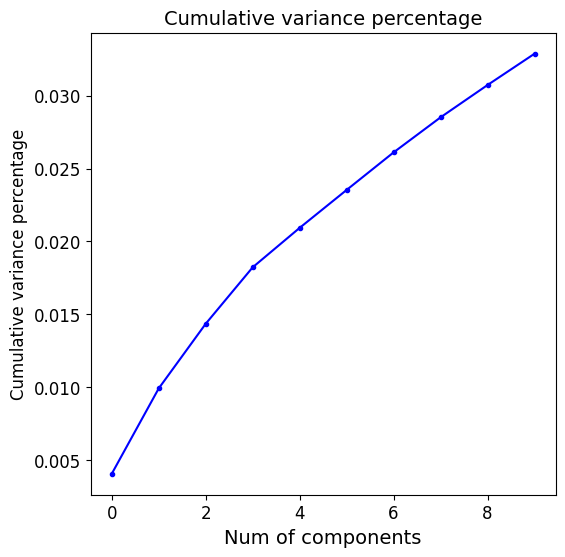

In [33]:
# Plot the cumulative variance percentage.
explained: np.ndarray = svd.explained_variance_ratio_.cumsum()
plt.figure(figsize=(6, 6))
plt.plot(explained, ".-", ms=6, color="b")
plt.xlabel("Num of components", fontsize=14)
plt.ylabel("Cumulative variance percentage", fontsize=12)
plt.title("Cumulative variance percentage", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


# Create the classifier.
rf_clf: RandomForestClassifier = RandomForestClassifier(
    n_estimators=100, random_state=random_state
)

# Fit the classifier with the train data.
rf_clf.fit(X_svd_train, train_data.target)

# Get the predicted classes.
test_class_pred: np.ndarray = rf_clf.predict(X_svd_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.8771704180064309

In [35]:
from utils.ml import train_model_with_cross_validation, plot_confusion_matrix

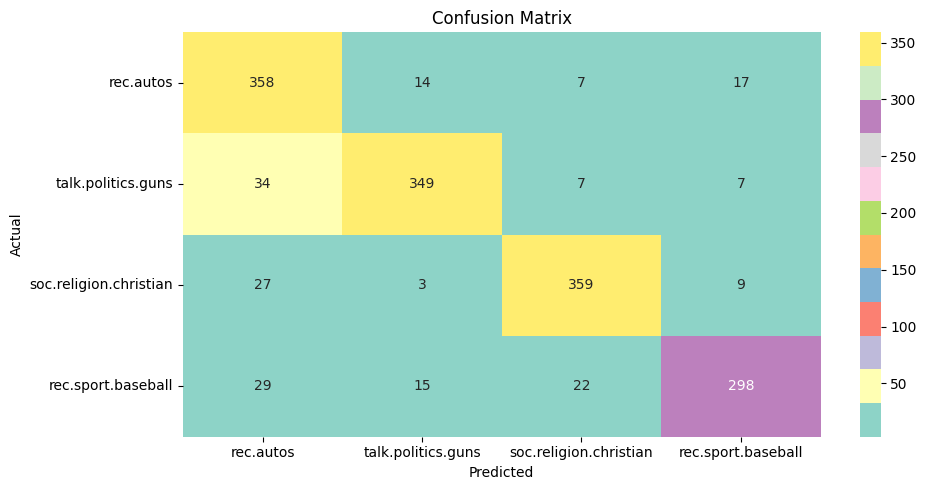

In [36]:
plot_confusion_matrix(test_data.target, test_class_pred, labels=categories)

### Train Model With Cross-validation

In [37]:
rf_clf: RandomForestClassifier = RandomForestClassifier(
    n_estimators=100, random_state=random_state
)
rf_clf, _, _, _ = train_model_with_cross_validation(
    X=X_svd_train,
    y=train_data.target,
    estimator=rf_clf,
    n_splits=5,
)
# Get the predicted classes.
train_class_pred: np.ndarray = rf_clf.predict(X_svd_train)
test_class_pred: np.ndarray = rf_clf.predict(X_svd_test)

Fold:  1 | Class dist.: [475 477 480 436] | Acc: 0.893
Fold:  2 | Class dist.: [476 477 479 437] | Acc: 0.863
Fold:  3 | Class dist.: [475 478 479 437] | Acc: 0.906
Fold:  4 | Class dist.: [475 478 479 437] | Acc: 0.884
Fold:  5 | Class dist.: [475 478 479 437] | Acc: 0.884

CV accuracy: 0.886 +/- 0.014

Time taken: 3.730 seconds


In [38]:
metrics.accuracy_score(test_data.target, test_class_pred)

0.8790996784565916